This Jupyter Notebook plots and analyzes ligand-detected 19F nuclear magnetic resonance spectroscopy (NMR) data of 5-fluoroindole in the absence and presence of varying concentrations of the non-structural protein 5A, domains 2 and 3 (NS5A-D2D3). Data should first be downloaded from Zenodo as detailed in ../README.md. Data are in .ft2 format. Filenames indicate protein concentration and replica index (e.g. '28_7uM_0.ft2' indicates 28.7uM NS5A-D2D3, first replicate). The concentration of 5-fluoroindole was held constant at 50 uM in all experiments. Output data are written to json files in ../json/ and are used for the tau_c_fit.

In [1]:
# Import useful stuff
%matplotlib inline
import os, sys
import nmrglue as ng
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import subplots
from scipy.optimize import curve_fit
from fit_raw import * # the included fit_raw.py file contains some useful functions

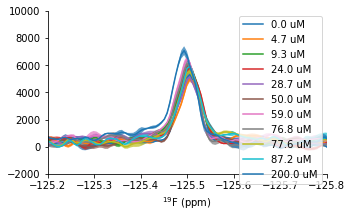

In [2]:
# Plot various 1D 19F NMR curves

# Create an instance of the fit_raw class
fit_1D_19F = fit_raw()

# Read and process the data
dic, data = fit_1D_19F.read_data('../Data/19F_1D_ft2_data/')

# Create a dictionary to group data by concentration
group_dict = {}
for key in data.keys():
    prefix = key.split('_')[1:3]
    prefix_dec = prefix[1].split('uM')
    join = prefix[0] + "." + "".join(prefix_dec)
    if join.startswith('d'):
        continue
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Sort the dictionary keys by concentration
sorted_keys = sorted(group_dict.keys(), key=lambda x: float(x.split('uM')[0]))

# Create the plot
fig, ax = plt.subplots(figsize=(5,3))

# Loop over grouped data, calculate average and standard error, and plot
for prefix in sorted_keys:
    keys = group_dict[prefix]
    # Collect the data and calculate average and standard error
    spectra = []
    for key in keys:
        spectra.append(data[key])
    avg_spectrum = np.mean(spectra, axis=0)
    ste_spectrum = np.std(spectra, axis=0) / np.sqrt(len(spectra))

    # Get the x-axis values (ppm_real)
    udic = ng.pipe.guess_udic(dic[keys[0]], data[keys[0]])
    ppm_real = np.linspace(-120+-(udic[0]['sw']/udic[0]['obs'])/2, -120+(udic[0]['sw']/udic[0]['obs'])/2, num=data[keys[0]].shape[0])

    # Plot the average spectrum with standard error
    ax.plot(ppm_real, avg_spectrum, label=prefix + " uM")
    ax.fill_between(ppm_real, avg_spectrum-ste_spectrum, avg_spectrum+ste_spectrum, alpha=0.7)

# Format plot
plt.xlabel('Frequency (Hz)')
ax.axes.get_yaxis().set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_xlabel("$^{19}$F (ppm)")
ax.set_xlim(-125.2, -125.8)
ax.set_ylim(-2000,10000)
ax.legend()

# Show the plot
plt.show()


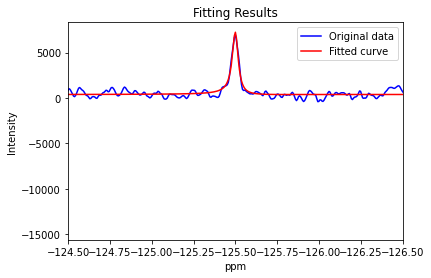

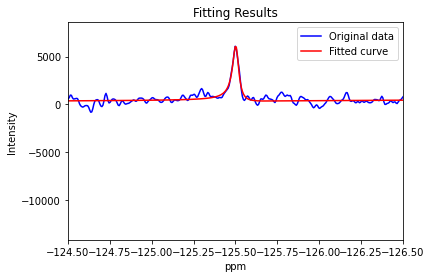

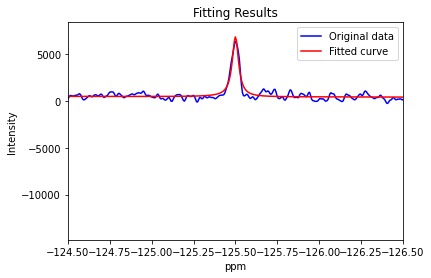

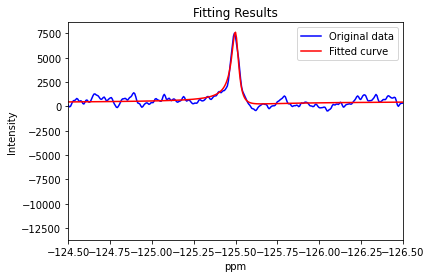

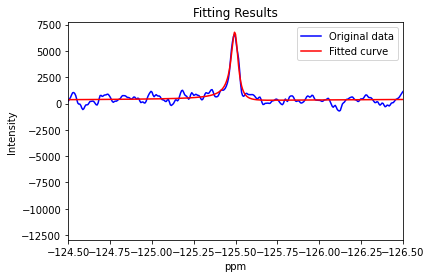

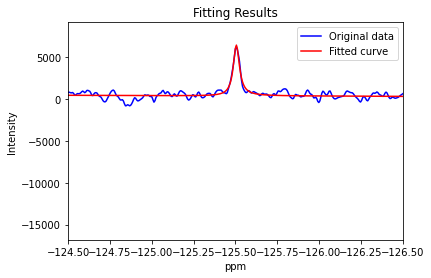

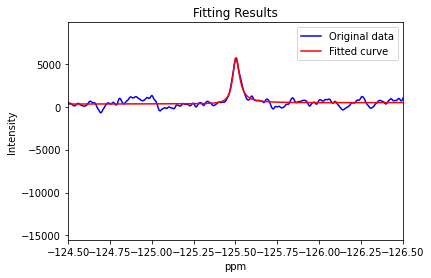

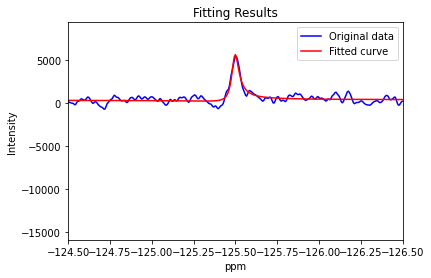

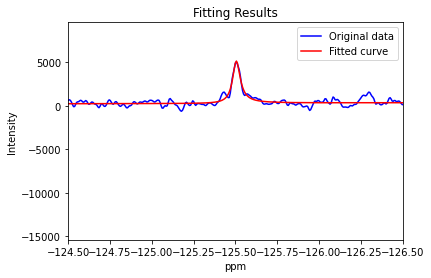

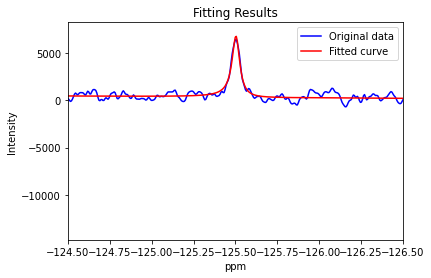

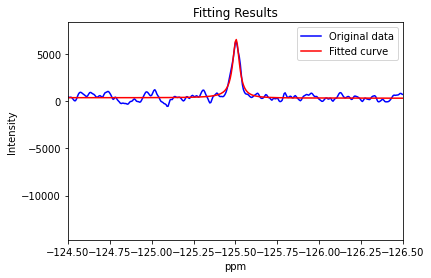

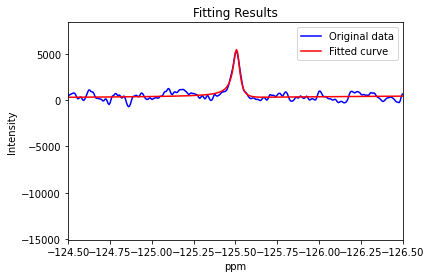

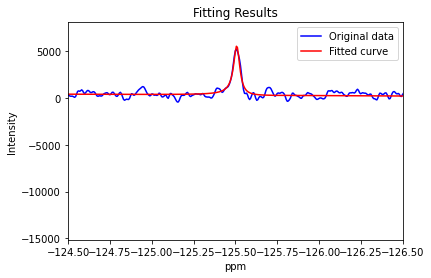

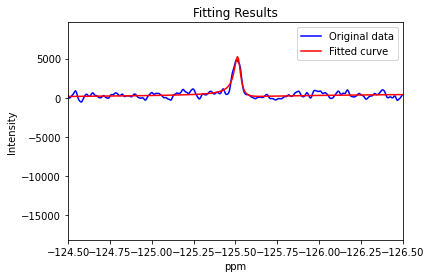

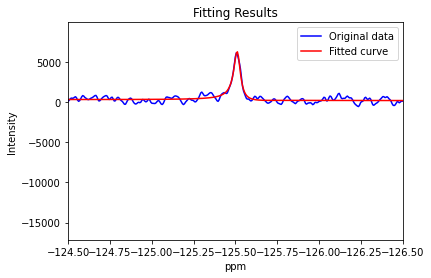

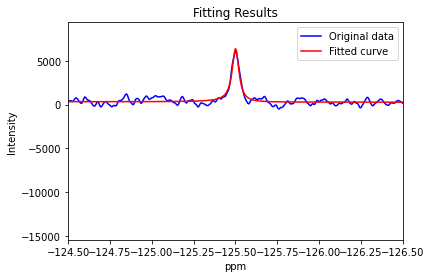

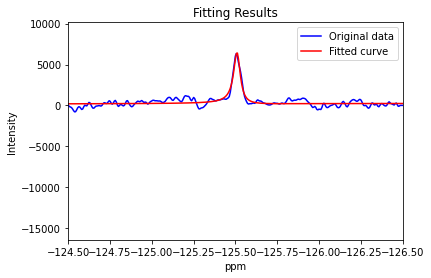

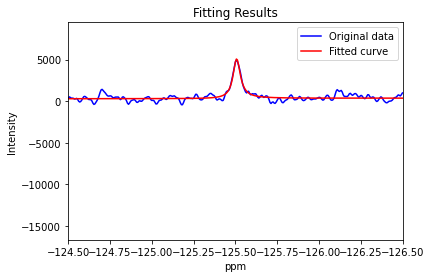

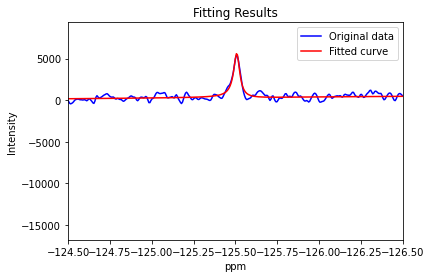

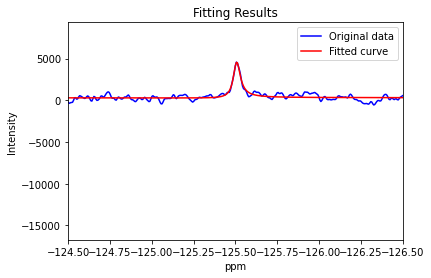

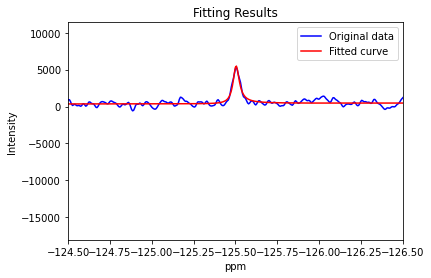

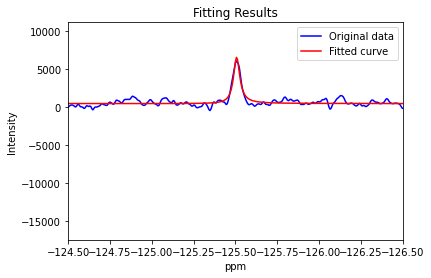

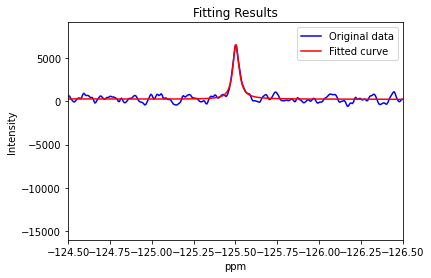

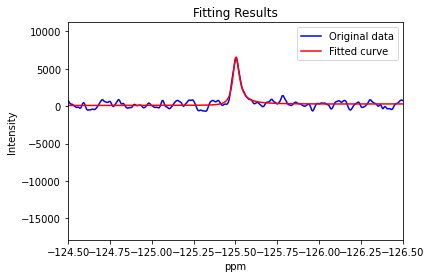

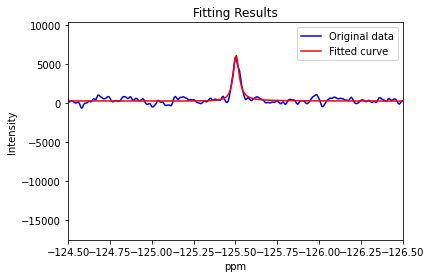

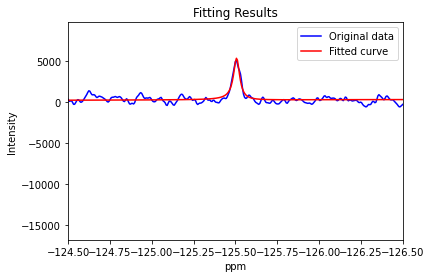

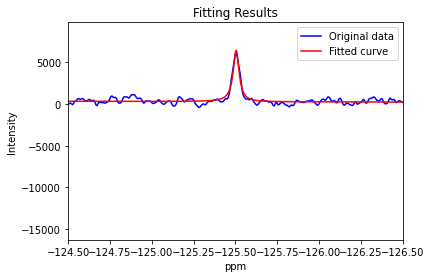

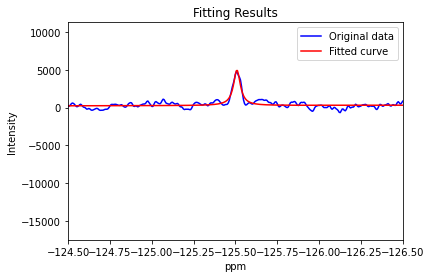

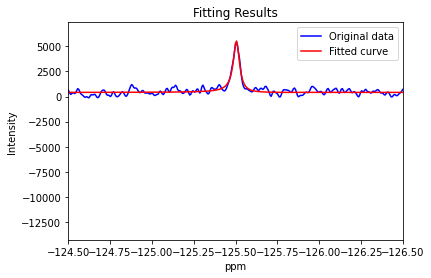

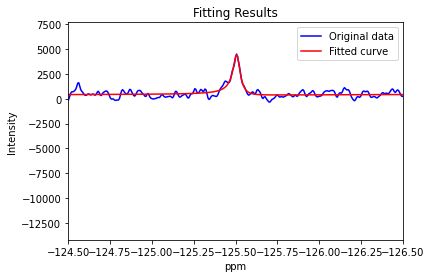

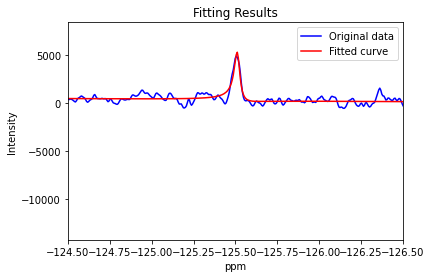

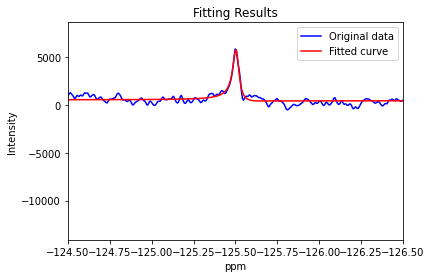

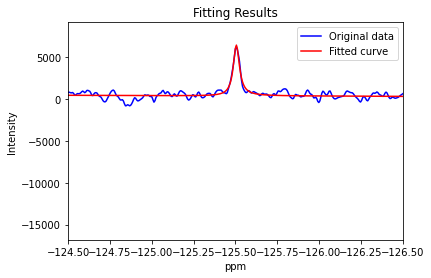

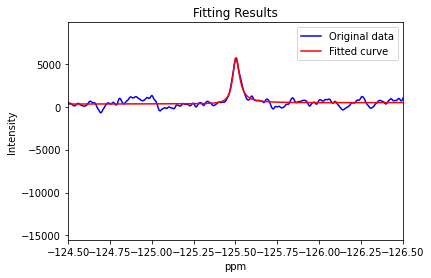

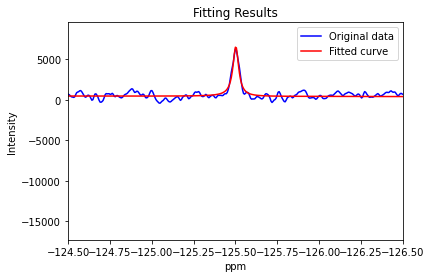

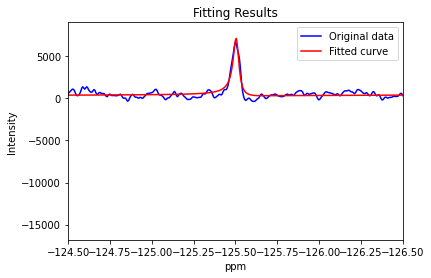

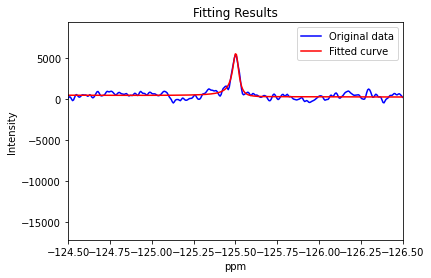

In [3]:
# Fit the locations of 19F chemical shifts

# Create an instance of the fit_raw class
fit_obj = fit_raw()

# Create a dictionary to store vals by concentration
concs_f0s_av = {}
concs_f0s_se = {}

# Loop over grouped data, calculate average and standard error, and plot
for key in group_dict:
    # Calculate average and standard error
    f0_vals = []
    f0_errs = []
    for i in group_dict[key]:
        popt, perr, fit_curve = fit_obj.fit_1D(dic=dic[i], data=data[i])
        f0_vals.append(popt[0])
        f0_errs.append(perr[0])
    concs_f0s_av[key] = np.mean(f0_vals, axis=0)
    concs_f0s_se[key] = np.sqrt(np.sum(np.asarray(f0_errs)**2)/3)

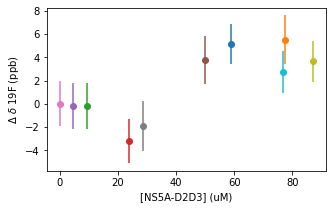

In [4]:
# Plot 19F chemical shift perturbation as a function of NS5A-D2D3 concentration
fig, ax = plt.subplots(figsize=(5,3))
for key in concs_f0s_av:
    if np.float(key) != 200.0: #uncomment this to include high concentration point
        ax.scatter(np.float(key), 10**3*(concs_f0s_av[key]-concs_f0s_av['0.0']))
        ax.errorbar(np.float(key), 10**3*(concs_f0s_av[key]-concs_f0s_av['0.0']), yerr=10**3*np.sqrt(concs_f0s_se[key]**2+concs_f0s_se['0.0']**2))
        ax.set_xlabel('[NS5A-D2D3] (uM)')
        ax.set_ylabel('$\Delta$ $\delta$ 19F (ppb)')
ax.ticklabel_format(useOffset=False)
plt.show()

In [5]:
# Save the dictionaries to json files in ../json to be used in tau_c_fit
with open('../json/CS_av.json', 'w') as outfile:
    json.dump(concs_f0s_av, outfile)
    
with open('../json/CS_se.json', 'w') as outfile:
    json.dump(concs_f0s_se, outfile)